## Extended DDM brief analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import data_reader
import matplotlib.patches as mpatches
import os
import matplotlib.lines as mlines
from matplotlib import rcParams

%matplotlib inline

### First, read the data exported from the matlab script

In [2]:
rcParams['savefig.format'] = 'eps'
rcParams['savefig.dpi'] = 300
model_output_path = '../output/csv/'

with open('figure_path.txt') as f:
    figure_path = f.read()
    
# csv files variables- for better readability:
eDDM_pcom = pd.read_csv(os.path.join(model_output_path, 'eDDM_pcom.txt'), sep=',')
eDDM_pcom = eDDM_pcom.iloc[1:]
eDDM_psychometric = pd.read_csv(os.path.join(model_output_path, 'eDDM_psychometric.txt'), sep=',')
eDDM_psychometric_CoM= pd.read_csv(os.path.join(model_output_path, 'eDDM_psychometric_CoM.txt'), sep=',')
eDDM_response_times = pd.read_csv(os.path.join(model_output_path, 'eDDM_response_times.txt'), sep=',')
eDDM_tertiles = pd.read_csv(os.path.join(model_output_path, 'eDDM_tertiles.txt'), sep=',')
eDDM_tertiles['RT tertile'] = pd.qcut(eDDM_tertiles['hand_IT'], 3, labels=[1, 2,3])
eDDM_tertiles['is_com'] = eDDM_tertiles['is_com'].astype('bool')
eDDM_tertiles['coherence'] /= 100

eDDM_stim_off_pcom = pd.read_csv(os.path.join(model_output_path, 'eDDM_stim_off_pcom.txt'), sep=',')
eDDM_stim_off_pcom = eDDM_stim_off_pcom.iloc[1:]
eDDM_stim_off_tertiles = pd.read_csv(os.path.join(model_output_path, 'eDDM_stim_off_tertiles.txt'), sep=',')
eDDM_stim_off_tertiles['RT tertile'] = pd.qcut(eDDM_stim_off_tertiles['hand_IT'], 3, labels=[1, 2,3])
eDDM_stim_off_tertiles['is_com'] = eDDM_stim_off_tertiles['is_com'].astype('bool')
eDDM_stim_off_tertiles['coherence'] /= 100

In [3]:
def plot_eDDM_rt(ax, eDDM_response_times):
    ax.errorbar(x=range(5), y=eDDM_response_times.init_times[1::], yerr=eDDM_response_times.init_times_sem[1::],
                 ls='-', fmt='-s',color='black', label='Correct', marker='o', lw=3, ms=8)
     
#     ax.set_xlabel('Coherence')
    ax.set_ylabel('Response time (ms)')
    ax.set_xticks(range(5))
    ax.set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))

In [4]:
def plot_eDDM_p_com(ax, eDDM_pcom):
    ax.plot(range(5), eDDM_pcom.p_com_correct, marker = 'o', color='black', label='correct', lw=3, ms=8, ls='-')
    ax.plot(range(5), eDDM_pcom.pcom_incorrect, marker = 'x',color='grey', label='error', lw=3, ms=8, ls='--')
    ax.legend()

    ax.set_xticklabels(('0.032', '0.064', '0.128', '0.256', '0.512'))

In [5]:
def get_p_com_per_var(c, var):
    return np.array([(len(c[(c.is_com) & (c.coherence==coherence) & (c[var]==var_level)]) / 
                   len(c[(c.coherence==coherence)])) 
               if len(c[(c.coherence==coherence) & (c[var]==var_level)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique())
           for var_level in np.sort(c[var].unique())])
    
def get_ci_vs_var(choices, var, n_threshold=0):
    p_com = get_p_com_per_var(choices, var)    

    n = choices.groupby(by=['coherence', var]).apply(len)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(choices.coherence.unique()), 
                                                          np.sort(choices[var].unique())], 
                                                         names=['coherence', var]))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(ax, data, var, n_threshold=0):
    ci = get_ci_vs_var(data, var, n_threshold=n_threshold)

    ax = sns.pointplot(data=ci, x='coherence', y='p_com', hue=var, palette='viridis_r', markers=['o', '^', 's'],
                       ax=ax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True, 
              title=var, title_fontsize=18)

All panels on one plot

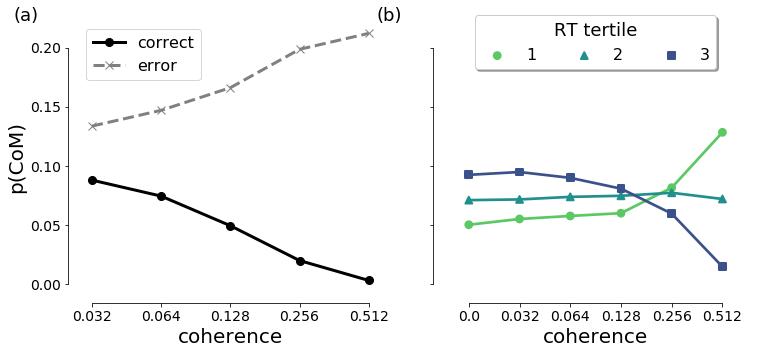

In [6]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot_eDDM_rt(ax1, eDDM_response_times)
# plot_eDDM_p_com(ax1, eDDM_pcom)
# plot_p_com_vs_var_ci(ax2, eDDM_tertiles, 'RT tertile', n_threshold=10)
# Here we report the same P(CoM) results  with stimulus switched off upon 1st threshold crossing.
plot_eDDM_p_com(ax1, eDDM_stim_off_pcom)
plot_p_com_vs_var_ci(ax2, eDDM_stim_off_tertiles, 'RT tertile', n_threshold=10)

# ax1.set_xlabel('')    
# ax2.set_xlabel('')
ax1.set_xlabel('coherence')    
ax2.set_xlabel('coherence')

ax1.set_ylabel('p(CoM)')    
ax2.set_ylabel('')
# ax3.set_ylabel('p(CoM)')    
# ax4.set_ylabel('')

fig.text(0.05, 0.88, '(a)', fontsize=18)
fig.text(0.47, 0.88, '(b)', fontsize=18)
# fig.text(0.05, 0.49, '(c)', fontsize=18)
# fig.text(0.47, 0.49, '(d)', fontsize=18)

sns.despine(trim=True, offset=10)
plt.savefig(os.path.join(figure_path, 'eddm_results') , bbox_inches='tight')